# Sampling Reviews for Annotation

Criteria:

- balanced number of reviews across all genres.
    - skip non-fiction and other fiction?
- reviews across all ratings and length bins
- reviews across platforms (not essential)
    - include NBD Biblion reviews?
- review date?
- reviewer prolificness?

Number of reviews: 1500

In [1]:
review_stats_file = '../data/review_features/reviews-stats-no_dups.tsv.gz'
isbn_work_id_mappings_file = "../data/book_metadata/work_isbn_title_genre.tsv.gz"


In [2]:
from impfic_core.map.map_genre import read_genre_file

# read work theme mapping
work_genre = read_genre_file(isbn_work_id_mappings_file)
work_genre = work_genre[['work_id', 'nur_genre']].drop_duplicates()



In [15]:
import pandas as pd


# read review metadata
review_stats = pd.read_csv(review_stats_file, sep='\t', compression='gzip')

# merge review metadata and theme data
review_stats = pd.merge(review_stats, work_genre[['work_id', 'nur_genre']].drop_duplicates(), 
                        on='work_id', how='left')

# remove reviews with no words
review_stats = review_stats[review_stats.review_num_words > 0]

# remove duplicate reviews with alternative work ID
review_stats = review_stats.groupby('review_id').first().reset_index()

# add unknown when no nur_genre is provided
review_stats['nur_genre'] = (review_stats
                             .nur_genre
                             .apply(lambda x: 'unknown' if pd.isna(x) else x))



In [29]:
import numpy as np


review_stats['log_num_words'] = review_stats.review_num_words.apply(lambda x: np.log(x+1))

In [30]:
# remove professional reviews
#review_stats = review_stats[review_stats.source != 'NBD_Biblion']
review_stats.source.value_counts()

Bol            254080
Hebban         210583
Goodreads       90600
WLJN            38210
NBD_Biblion     36310
Dizzie          26873
Boekmeter        7250
LTL              7004
Name: source, dtype: int64

In [31]:
review_stats.nur_genre.value_counts()

Literary_fiction      201090
Non-fiction           108891
unknown                94985
Literary_thriller      77059
Suspense               68562
Other fiction          37414
Young_adult            30263
Children_fiction       27461
Fantasy_fiction        13762
Romance                 6428
Historical_fiction      3467
Regional_fiction        1528
Name: nur_genre, dtype: int64

In [86]:
not_genres = ['unknown', 'Non-fiction']
not_sources = ['Boekmeter', 'Dizzie', 'WLJN', 'LTL']

filtered_step_1 = review_stats[(review_stats.nur_genre.isin(not_genres) == False)]
filtered_step_1 = filtered_step_1[(filtered_step_1.source.isin(not_sources) == False)]
filtered_step_1 = filtered_step_1[filtered_step_1.review_num_words >= 10]
filtered_step_1.shape

(387221, 12)

In [87]:
random_state = 11
filtered_step_1.nur_genre.value_counts()
anno_sample_step_1 = filtered_step_1.groupby('nur_genre').sample(100, random_state=random_state)

In [88]:
anno_sample_step_1.source.value_counts()

Hebban         488
Bol            393
Goodreads       68
NBD_Biblion     51
Name: source, dtype: int64

**Observation**: few reviews from Dizzie and especially Boekmeter.

In [89]:
print(f"number of reviews with no rating: {len(anno_sample_step_1[anno_sample_step_1.rating.isna()])}")
anno_sample_step_1.rating.value_counts()

number of reviews with no rating: 51


5.0    388
4.0    348
3.0    143
2.0     44
1.0     21
0.0      5
Name: rating, dtype: int64

**Observation**: very few reviews with a low rating (below 3.0).

max review length: 1964


<Axes: xlabel='log_num_words', ylabel='Density'>

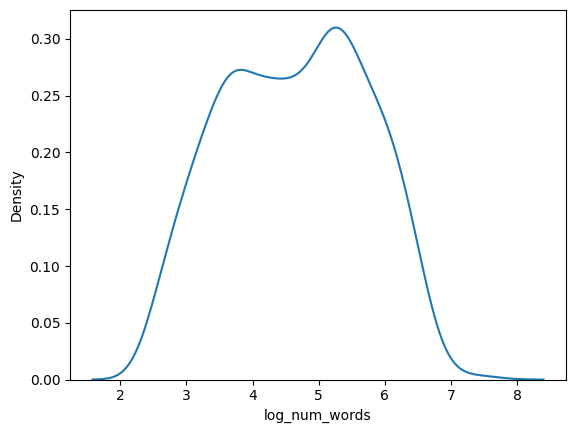

In [90]:
import seaborn as sns

print('max review length:', anno_sample_step_1.review_num_words.max())
sns.kdeplot(anno_sample_step_1.log_num_words)

**Observation**: the length distribution looks good. There are very few short reviews, but that's not a problem. There are also not many very long reviews, but again, that's not a problem. As long as there are some.

In [92]:
anno_sample_step_1[anno_sample_step_1.review_num_words > 100].shape

(520, 12)

In [94]:
anno_sample_step_1[['review_num_words', 'log_num_words']]

,review_num_words,log_num_words
12517,227,5.429346
235724,124,4.828314
32980,175,5.170484
321754,147,4.997212
22827,725,6.587550
...,...,...
280040,116,4.762174
196871,66,4.204693
474218,380,5.942799
54901,188,5.241747


In [95]:
filtered_step_2 = filtered_step_1[filtered_step_1.review_id.isin(anno_sample_step_1.review_id) == False]
len(filtered_step_1), len(filtered_step_2)

(387221, 386221)

## Adding reviews from under-represented platforms

In [98]:
source_num_sampled = anno_sample_step_1.source.value_counts()
source_num_sampled

Hebban         488
Bol            393
Goodreads       68
NBD_Biblion     51
Name: source, dtype: int64

In [106]:
min_source_num = 100

source_samples = []
for source in source_num_sampled.index:
    to_add = min_source_num - source_num_sampled[source] if source_num_sampled[source] < min_source_num else 0
    if to_add == 0:
        continue
    print('under-represented:', source, to_add)
    # sample from reviews not in the annotation sample
    source_sample = filtered_step_2[filtered_step_2.source == source].sample(to_add, random_state=random_state)
    source_samples.append(source_sample)

anno_sample_step_2 = pd.concat([anno_sample_step_1] + source_samples)
filtered_step_3 = filtered_step_2[filtered_step_2.review_id.isin(anno_sample_step_2.review_id) == False]
print('unsampled reviews:', len(filtered_step_3))

print('reviews sampled per source:')
anno_sample_step_2.source.value_counts()

under-represented: Goodreads 32
under-represented: NBD_Biblion 49
unsampled reviews: 386140
reviews sampled per source:


Hebban         488
Bol            393
NBD_Biblion    100
Goodreads      100
Name: source, dtype: int64

## Adding reviews with low ratings

In [110]:
target_num_reviews = 1400

to_sample = target_num_reviews - len(anno_sample_step_2)
print('reviews left to sample:', to_sample)

reviews left to sample: 319


In [114]:
low_rating = filtered_step_3[filtered_step_3.rating < 3.0]
#low_rating_sample = low_rating.groupby('source').
low_rating.source.value_counts()
low_rating.rating.value_counts()

# sample the remaining reviews from the ones with low ratings
rating_sample = low_rating.sample(to_sample, random_state=random_state)

# combine the samples
anno_sample_step_3 = pd.concat([anno_sample_step_2, rating_sample])

In [123]:
print('number of sampled reviews:', len(anno_sample_step_3))
print('number of reviews longer than 100 words:', len(anno_sample_step_3[anno_sample_step_3.review_num_words > 100]))

print('reviews per ratign:')
anno_sample_step_3.rating.value_counts()

number of sampled reviews: 1400
number of reviews longer than 100 words: 720
reviews per ratign:


5.0    394
4.0    365
2.0    259
3.0    148
1.0    123
0.0     10
Name: rating, dtype: int64

In [121]:
print('reviews per platform:')
anno_sample_step_3.source.value_counts()

reviews per platform:


Hebban         632
Bol            504
Goodreads      164
NBD_Biblion    100
Name: source, dtype: int64

In [122]:
print('reviews per genre:')
anno_sample_step_3.nur_genre.value_counts()

reviews per genre:


Literary_fiction      297
Suspense              169
Literary_thriller     164
Other fiction         130
Young_adult           116
Children_fiction      109
Fantasy_fiction       107
Historical_fiction    105
Romance               102
Regional_fiction      101
Name: nur_genre, dtype: int64

In [133]:
anno_sample_step_3.groupby('source').rating.value_counts()

source     rating
Bol        5.0       225
           4.0       112
           2.0        77
           1.0        55
           3.0        35
Goodreads  2.0        55
           4.0        48
           1.0        23
           5.0        20
           3.0        17
Hebban     4.0       205
           5.0       149
           2.0       127
           3.0        96
           1.0        45
           0.0        10
Name: rating, dtype: int64

In [134]:
anno_sample_step_3.groupby('nur_genre').rating.value_counts()

nur_genre           rating
Children_fiction    5.0        54
                    4.0        32
                    3.0         7
                    1.0         5
                    0.0         4
                    2.0         1
Fantasy_fiction     5.0        46
                    4.0        32
                    2.0         9
                    3.0         9
                    1.0         4
Historical_fiction  4.0        39
                    5.0        38
                    3.0        13
                    2.0         7
                    1.0         4
Literary_fiction    2.0       121
                    1.0        48
                    4.0        39
                    5.0        37
                    3.0        26
                    0.0         1
Literary_thriller   2.0        48
                    4.0        38
                    5.0        28
                    1.0        22
                    3.0        18
Other fiction       5.0        38
                    4

In [128]:
anno_sample_step_3.to_csv('review_sample_annotation.tsv', sep='\t', index=False)

## Tokenizing sentences of sampled reviews

The reviews must be saved one per file, with each sentence on a separate line.

In [130]:
from trankit import Pipeline

# initialize a multilingual pipeline
p = Pipeline(lang='dutch', gpu=False, cache_dir='./cache')

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

http://nlp.uoregon.edu/download/trankit/v1.0.0/xlm-roberta-base/dutch.zip


Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46.3M/46.3M [00:12<00:00, 3.78MiB/s]


Loading pretrained XLM-Roberta, this may take a while...


Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Loading tokenizer for dutch
Loading tagger for dutch
Loading lemmatizer for dutch
Loading NER tagger for dutch
Active language: dutch


In [132]:
def write_review(review_id: str, review_text: str):
    review_file = f'data/sampled_reviews/{review_id}.txt'
    with open(review_file, 'wt') as fh:
        sentence_doc = p.ssplit(review_text)
        for sentence in sentence_doc['sentences']:
            fh.write(f"{sentence['text']}\n")

for idx, row in anno_sample_step_3.iterrows():
    write_review(row['review_id'], row['review_text'])
    